In [1]:
import torch, os, cv2, numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
import matplotlib.pyplot as plt
import albumentations as A
from glob import glob
from tqdm import tqdm
# from utils import *
import segmentation_models_pytorch as smp
from PIL import Image

/home/ubuntu/anaconda3/envs/retrieval/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/anaconda3/envs/retrieval/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [123]:
glob('/kaggle/input/flood-area-segmentation/Image')

['/kaggle/input/flood-area-segmentation/Image']

In [6]:
class Segmentations(Dataset):
    def __init__(self, root, transformations=None):
        self.transformations = transformations
        self.tensorize = T.Compose([T.ToTensor()])
        self.im_path_jpg = sorted(glob(f"{root}/images/*"))
        self.im_mask_png = sorted(glob(f"{root}/masks/*"))

        self.total_ims = len(self.im_path_jpg)
        self.total_gts = len(self.im_mask_png)

        assert self.total_ims == self.total_gts
        print(f'There are {self.total_ims} images and {self.total_gts} masks in the dataset')

    def __len__(self):
        return len(self.im_path_jpg)

    def __getitem__(self, idx):
        im = np.array(Image.open(self.im_path_jpg[idx]).convert('RGB'))
        gt = np.array(Image.open(self.im_mask_png[idx]))

        if self.transformations is not None:
            transformed = self.transformations(image=im, mask=gt)
            im, gt = transformed['image'], transformed['mask']

        return self.tensorize(im), torch.tensor(gt > 128).long()


def get_transformation(size):
    tfs = A.Compose([A.Resize(size, size)])
    return tfs

tfs = get_transformation(256)
ds = Segmentations(root='/home/ubuntu/workspace/dataset/bekhzod/sem_segmentation/flood', transformations=tfs)
print(type(ds[0][0]))
print(ds[0][1].shape)

There are 289 images and 289 masks in the dataset
<class 'torch.Tensor'>
torch.Size([256, 256])


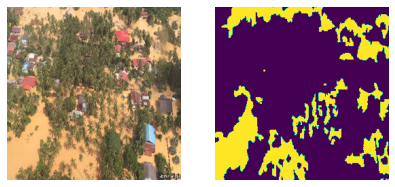

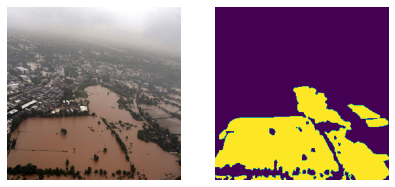

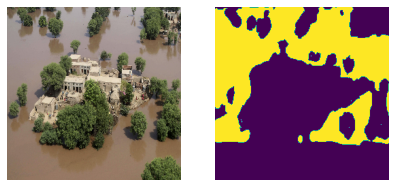

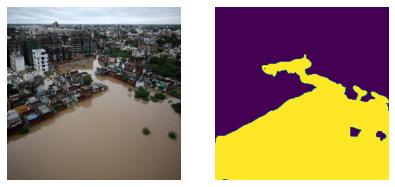

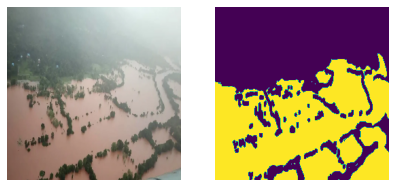

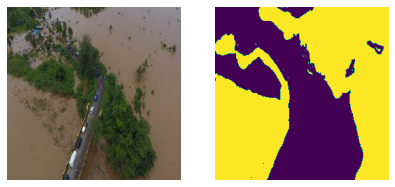

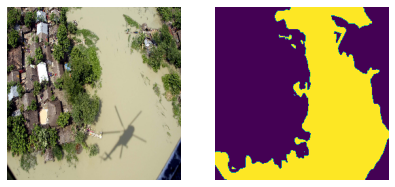

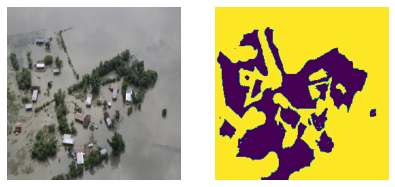

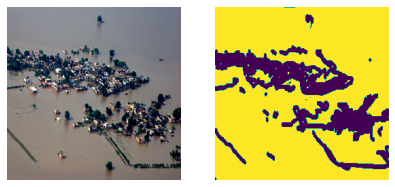

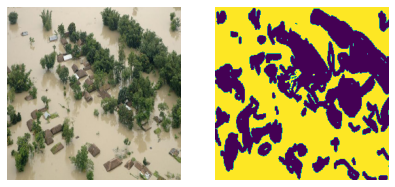

<Figure size 1296x1296 with 0 Axes>

In [7]:
def showing(ds, img_num=10, row=2):
    for idx, (im, gt) in enumerate(ds):
        count = 1
        plt.figure(figsize=(18,18))
        if idx == 10: break
        im = (im * 255).detach().cpu().permute(1,2,0).numpy().astype('uint8')# integer 8
        gt = (gt * 255).detach().cpu().numpy().astype('uint8')
        plt.subplot(row, img_num // row, count)
        plt.imshow(im)
        plt.axis('off')
        count += 1
        plt.subplot(row, img_num // row, count)
        plt.imshow(gt)
        plt.axis('off')
        count += 1
        plt.show()
        
showing(ds, 10, 2)    

In [9]:
def get_dl(root, transformations, bs, split = [0.7, 0.15, 0.15]):
    
    assert sum(split) == 1
    # Get dataset
    ds = Segmentations(root = "/home/ubuntu/workspace/dataset/bekhzod/sem_segmentation/flood", transformations = tfs)
    
    tr_len = int(split[0] * len(ds))
    val_len = int(split[1] * len(ds))
    test_len = len(ds) - (tr_len + val_len)
    # Data split
    tr_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [tr_len, val_len, test_len])
    
    print(f"There are {len(tr_ds)} images in the trainset")
    print(f"There are {len(val_ds)} images in the validation set")
    print(f"There are {len(test_ds)} images in the test set")
    
    tr_dl = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True)
    val_dl = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False)
    test_dl = DataLoader(dataset = test_ds, batch_size = bs, shuffle = False)
    
    return tr_dl, val_dl, test_dl 
    
tr_dl, val_dl, test_dl = get_dl(root = "data", bs = 64, transformations = tfs) 


There are 289 images and 289 masks in the dataset
There are 202 images in the trainset
There are 43 images in the validation set
There are 44 images in the test set


In [10]:
class Metrics():
    
    def __init__(self, pred, gt, loss_fn, eps = 3e-4, n_cls = 2):
        
        
        self.pred_ = pred # to compute loss value
        self.pred, self.gt = torch.argmax(torch.nn.functional.softmax(pred, dim = 1)), gt 
        self.pred, self.gt = torch.argmax(torch.nn.functional.softmax(pred, dim = 1), dim = 1), gt 
        self.loss_fn, self.eps, self.n_cls = loss_fn, eps, n_cls
        
    def to_contiguous(self, inp): return inp.contiguous().view(-1) # (3, 224, 224) -> (3 * 224 * 224)

    def PA(self):
        
        with torch.no_grad():
            
            match = torch.eq(self.pred, self.gt).int()
            
        return float(match.sum()) / float(match.numel()) # numel() is a number of elements in match
    
    def mIoU(self):
        
        with torch.no_grad():
            
            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)
            
            iou_per_class = []
            
            for c in range(self.n_cls):
                
                match_pred = pred == c
                match_gt   = gt   == c
                
                # If there is no background class
                if match_gt.long().sum().item() == 0: iou_per_class.append(np.nan)
                
                else:
                    
                    intersection = torch.logical_and(match_pred, match_gt).sum().float().item()
                    union = torch.logical_or(match_pred, match_gt).sum().float().item()
                    
                    iou = (intersection) / (union + self.eps)
                    iou_per_class.append(iou)
                    
            return np.nanmean(iou_per_class)
    
    def loss(self): return self.loss_fn(self.pred_, self.gt)
    



In [11]:
model = smp.Unet(encoder_name = 'resnet18',
               encoder_weights = 'imagenet',
               in_channels = 3,
               classes = 2,
               encoder_depth = 5,
               decoder_channels = [256,128,64,32,16])

In [12]:
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(params = model.parameters(), lr = 3e-4)

In [13]:
def train(model, tr_dl, val_dl, loss_fn, opt, epochs, device, patience):
    
    tr_loss, tr_pa, tr_iou = [], [], []
    val_loss, val_pa, val_iou = [], [], []
    tr_len, val_len = len(tr_dl), len(val_dl)
    best_loss = torch.tensor(float("inf"))
    not_improved = 0
    #os.makedirs("saved_models", exist_ok = True)
    
    model.to(device)
    for epoch in range(1, epochs + 1):  
        
        tr_loss_, tr_iou_, tr_pa_ = 0, 0, 0
        
        model.train()
        
        print(f"{epoch}-epoch train is started...")
        for idx, batch in enumerate(tqdm(tr_dl)):
            
            im, gt = batch
            im, gt = im.to(device), gt.to(device)
            
            pred = model(im)
            
            met = Metrics(pred = pred, gt = gt, loss_fn = loss_fn)
            
            loss_ = met.loss()
            
            tr_iou_ += met.mIoU()
            tr_pa_ += met.PA()
            tr_loss_ += loss_
            
            loss_.backward() 
            opt.step() 
            opt.zero_grad()
            
        print(f"{epoch}-epoch train is finished!")
        print(f"{epoch}-epoch validation is started...")
        
        model.eval()
        val_loss_, val_iou_, val_pa_ = 0, 0, 0
        
        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dl)):
            
                im, gt = batch
                im, gt = im.to(device), gt.to(device)

                pred = model(im)

                met = Metrics(pred = pred, gt = gt, loss_fn = loss_fn)

                val_iou_ += met.mIoU()
                val_pa_ += met.PA()
                val_loss_ += met.loss().item()
            
        print(f"{epoch}-epoch validation is finished!")
        
        tr_loss_ /= tr_len
        tr_iou_ /= tr_len
        tr_pa_ /= tr_len
        
        val_loss_ /= val_len
        val_iou_ /= val_len
        val_pa_ /= val_len
        
        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"\nEpoch {epoch} Train Process Results: \n")
        print(f"Train loss          -> {tr_loss_:.3f}")
        print(f"Train PA            -> {tr_pa_:.3f}")
        print(f"Train mIoU          -> {tr_iou_:.3f}")
        print(f"Validation loss     -> {val_loss_:.3f}")
        print(f"Validation PA       -> {val_pa_:.3f}")
        print(f"Validation mIoU     -> {val_iou_:.3f}")
        
        tr_loss.append(tr_loss_); tr_pa.append(tr_pa_); tr_iou.append(tr_iou_)
        val_loss.append(val_loss_); val_pa.append(val_pa_); val_iou.append(val_iou_)
        
        if best_loss < val_loss_:
            print(f"Loss value did not decrease")
            not_improved += 1
            if not_improved == patience:
                print(f"Stop training since loss value did not decrease for {patience} epochs.")
                break
        
        else:
            print(f"Loss decreased from {best_loss} to {val_loss_}")
            best_loss = val_loss_
                        
    return{"tr_loss": tr_loss, "tr_pa": tr_pa, "tr_iou": tr_iou,
              "val_loss": val_loss, "val_pa": val_pa, "val_iou": val_iou} 


In [14]:
his = train(model = model, tr_dl = tr_dl,
            val_dl = val_dl, loss_fn = loss_fn,
            opt = opt, epochs = 10, device = "cuda",
             patience = 4)

1-epoch train is started...


100%|██████████| 4/4 [00:14<00:00,  3.70s/it]


1-epoch train is finished!
1-epoch validation is started...


100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


1-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1 Train Process Results: 

Train loss          -> 0.706
Train PA            -> 0.579
Train mIoU          -> 0.409
Validation loss     -> 0.816
Validation PA       -> 0.579
Validation mIoU     -> 0.406
Loss decreased from inf to 0.816027820110321
2-epoch train is started...


100%|██████████| 4/4 [00:09<00:00,  2.36s/it]


2-epoch train is finished!
2-epoch validation is started...


100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


2-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 Train Process Results: 

Train loss          -> 0.510
Train PA            -> 0.788
Train mIoU          -> 0.649
Validation loss     -> 1.556
Validation PA       -> 0.465
Validation mIoU     -> 0.276
Loss value did not decrease
3-epoch train is started...


100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


3-epoch train is finished!
3-epoch validation is started...


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


3-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 Train Process Results: 

Train loss          -> 0.416
Train PA            -> 0.845
Train mIoU          -> 0.729
Validation loss     -> 0.858
Validation PA       -> 0.604
Validation mIoU     -> 0.427
Loss value did not decrease
4-epoch train is started...


100%|██████████| 4/4 [00:09<00:00,  2.34s/it]


4-epoch train is finished!
4-epoch validation is started...


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


4-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 Train Process Results: 

Train loss          -> 0.349
Train PA            -> 0.884
Train mIoU          -> 0.785
Validation loss     -> 0.542
Validation PA       -> 0.753
Validation mIoU     -> 0.604
Loss decreased from 0.816027820110321 to 0.541678786277771
5-epoch train is started...


100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


5-epoch train is finished!
5-epoch validation is started...


100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


5-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 Train Process Results: 

Train loss          -> 0.315
Train PA            -> 0.895
Train mIoU          -> 0.804
Validation loss     -> 0.450
Validation PA       -> 0.821
Validation mIoU     -> 0.691
Loss decreased from 0.541678786277771 to 0.45048442482948303
6-epoch train is started...


100%|██████████| 4/4 [00:09<00:00,  2.34s/it]


6-epoch train is finished!
6-epoch validation is started...


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


6-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 Train Process Results: 

Train loss          -> 0.274
Train PA            -> 0.908
Train mIoU          -> 0.825
Validation loss     -> 0.376
Validation PA       -> 0.845
Validation mIoU     -> 0.724
Loss decreased from 0.45048442482948303 to 0.37627220153808594
7-epoch train is started...


100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


7-epoch train is finished!
7-epoch validation is started...


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


7-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 Train Process Results: 

Train loss          -> 0.245
Train PA            -> 0.917
Train mIoU          -> 0.842
Validation loss     -> 0.353
Validation PA       -> 0.861
Validation mIoU     -> 0.748
Loss decreased from 0.37627220153808594 to 0.3526594042778015
8-epoch train is started...


100%|██████████| 4/4 [00:08<00:00,  2.17s/it]


8-epoch train is finished!
8-epoch validation is started...


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


8-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 Train Process Results: 

Train loss          -> 0.232
Train PA            -> 0.920
Train mIoU          -> 0.847
Validation loss     -> 0.325
Validation PA       -> 0.873
Validation mIoU     -> 0.763
Loss decreased from 0.3526594042778015 to 0.3246631324291229
9-epoch train is started...


100%|██████████| 4/4 [00:09<00:00,  2.27s/it]


9-epoch train is finished!
9-epoch validation is started...


100%|██████████| 1/1 [00:02<00:00,  2.00s/it]


9-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 Train Process Results: 

Train loss          -> 0.213
Train PA            -> 0.926
Train mIoU          -> 0.859
Validation loss     -> 0.317
Validation PA       -> 0.877
Validation mIoU     -> 0.768
Loss decreased from 0.3246631324291229 to 0.3172251582145691
10-epoch train is started...


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


10-epoch train is finished!
10-epoch validation is started...


100%|██████████| 1/1 [00:01<00:00,  1.97s/it]

10-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 Train Process Results: 

Train loss          -> 0.196
Train PA            -> 0.932
Train mIoU          -> 0.868
Validation loss     -> 0.303
Validation PA       -> 0.882
Validation mIoU     -> 0.777
Loss decreased from 0.3172251582145691 to 0.30267152190208435


In [15]:
def plot_results(his):
    tr_loss = [loss.item() for loss in his['tr_loss']]
    tr_pa = his["tr_pa"]
    tr_iou = his["tr_iou"]
    val_loss = his["val_loss"]
    val_pa = his["val_pa"]
    val_iou = his["val_iou"]

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(tr_loss, label="Train_Loss")
    plt.plot(val_loss, label="Validation_Loss")
    plt.title("Loss")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(tr_pa, label="Train_PA")
    plt.plot(val_pa, label="Validation_PA")
    plt.title("Pixel Accuracy (PA)")
    plt.ylabel("PA")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(tr_iou, label="Train_IoU")
    plt.plot(val_iou, label="Validation_IoU")
    plt.title("Intersection over Union (IoU)")
    plt.ylabel("IoU")
    plt.legend()

    plt.tight_layout()
    plt.show()

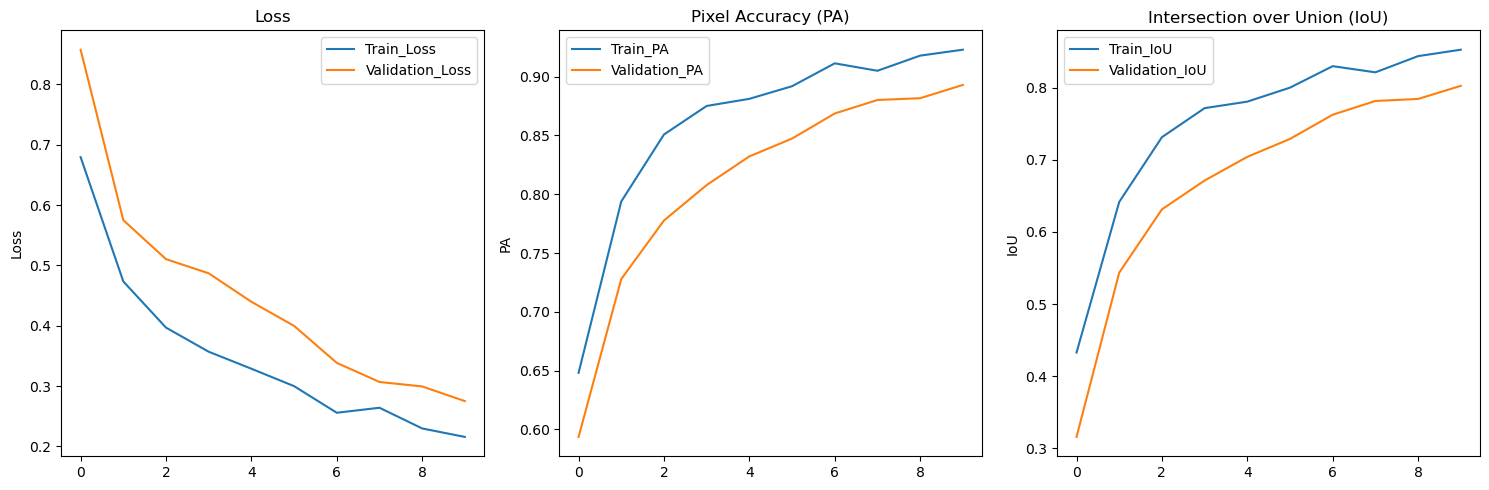

In [133]:
plot_results(his)

In [16]:
device = 'cuda'

In [59]:
ims, gts = next(iter(test_dl))
model.eval()
preds, images, lbls = [], [], []
for im, gt in zip(ims, gts):
    im, gt = im.to(device), gt.to(device)
    pred = model(im.unsqueeze(0)) 
    images.append(im)
    preds.append(pred)
    lbls.append(gt)
    
print(len(preds))

44


In [60]:
def tensor_2_im(t): return (t * 255).detach().cpu().permute(2, 1, 0).numpy().astype(np.uint8)

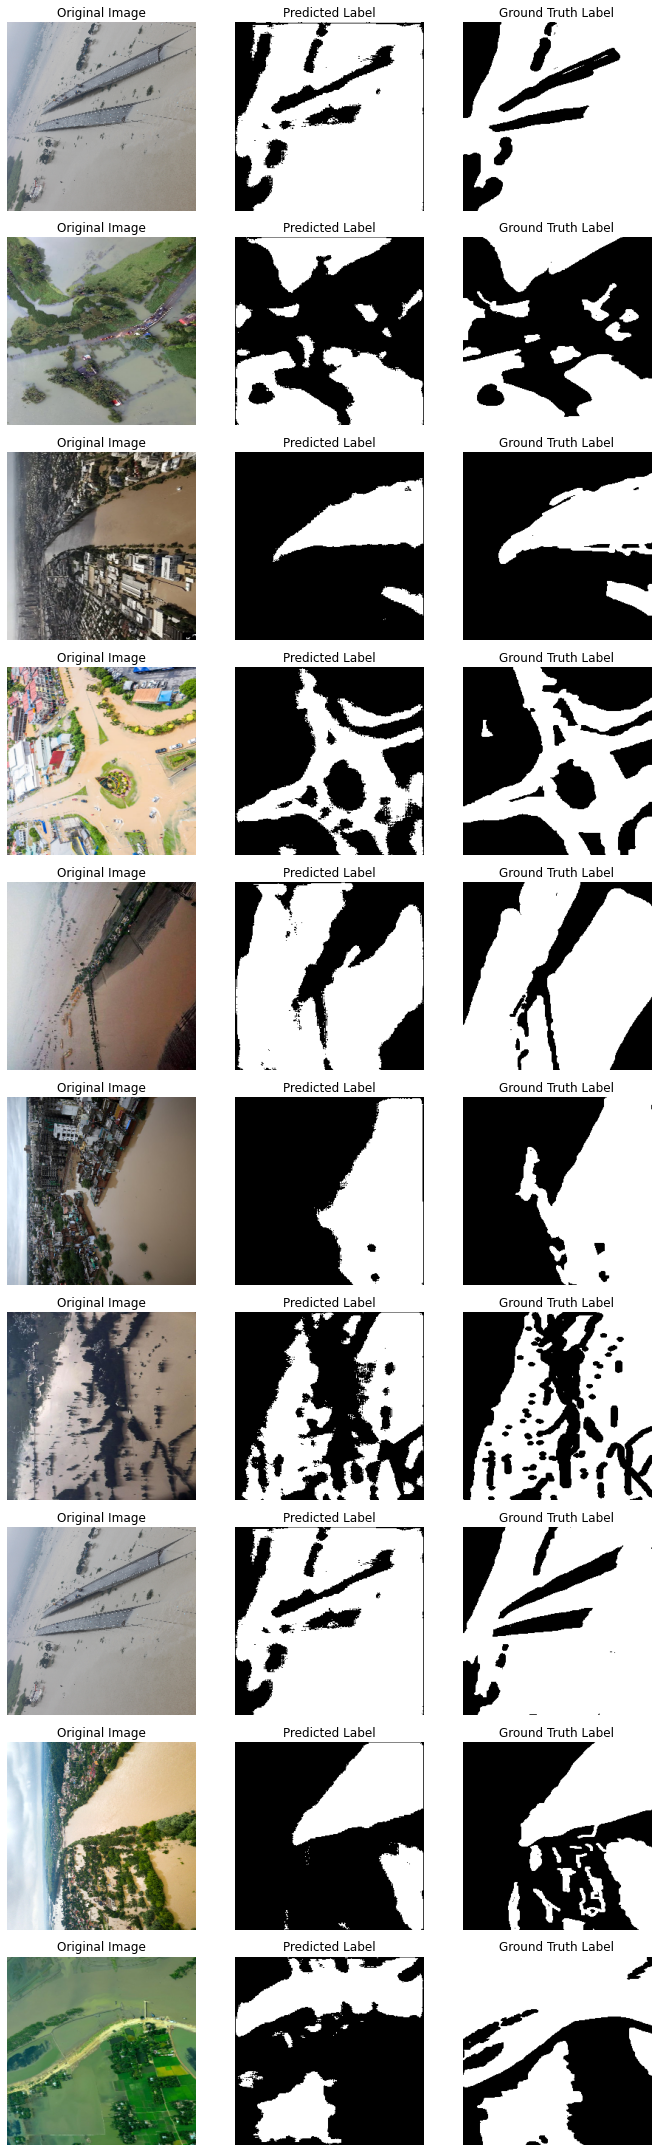

In [63]:
import random

indices = random.sample(range(len(images)), 10)
fig, axs = plt.subplots(10, 3, figsize=(10, 30))

for i, idx in enumerate(indices):
    im = images[idx]
    pred = preds[idx]
    gt = lbls[idx]

    # Plot the original image
    axs[i, 0].imshow(tensor_2_im(im))
    axs[i, 0].axis('off')
    axs[i, 0].set_title('Original Image')

    # Plot the predicted label
    axs[i, 1].imshow(tensor_2_im((pred > 0.5).squeeze(0))[:, :, 1], cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 1].set_title('Predicted Label')

    # Plot the ground truth label
    axs[i, 2].imshow(tensor_2_im(gt.unsqueeze(0)), cmap='gray')
    axs[i, 2].axis('off')
    axs[i, 2].set_title('Ground Truth Label')

plt.tight_layout()
plt.show()